In [53]:
from pystac_client import Client
from odc.stac import load
from odc.algo import geomedian_with_mads
import geopandas as gpd
from dea_tools.coastal import pixel_tides
from odc.algo import mask_cleanup
import xarray as xr

In [5]:
study_area = "9,19"
grid_path = "https://raw.githubusercontent.com/auspatious/dea-coastlines/stable/data/raw/vietnam_tiles.geojson"
stac_catalog = "https://earth-search.aws.element84.com/v1/"
stac_collection = "sentinel-2-l2a"
datetime = "2023"

client = Client.open(stac_catalog)

In [6]:
gridcell_gdf = gpd.read_file(grid_path).to_crs(epsg=4326).set_index("id")
gridcell_gdf.index = gridcell_gdf.index.astype(str)
geometry = gridcell_gdf.loc[[study_area]]

In [7]:
items = list(client.search(
    collections=[stac_collection],
    bbox=list(geometry.bounds.values[0]),
    datetime=datetime,
).items())

In [8]:
print(f"Found {len(items)} items")

Found 270 items


In [56]:
data = load(
    items,
    measurements=["red", "green", "blue", "scl"],
    resolution=100,
    chunks=dict(x=2048, y=2048),
    groupby="solar_day",
)

cloud_mask = data.scl.isin([3, 9])
cloud_mask = mask_cleanup(cloud_mask, mask_filters=[("closing", 5), ("opening", 5)])

data = data.where(~cloud_mask)

data

<xarray.Dataset>
Dimensions:      (time: 68, y: 2099, x: 2099)
Coordinates:
  * y            (y) float64 1.1e+06 1.1e+06 1.1e+06 ... 8.904e+05 8.902e+05
  * x            (x) float64 4e+05 4e+05 4.002e+05 ... 6.096e+05 6.098e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2023-01-05T03:35:28.291000 ... 2023-12...
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

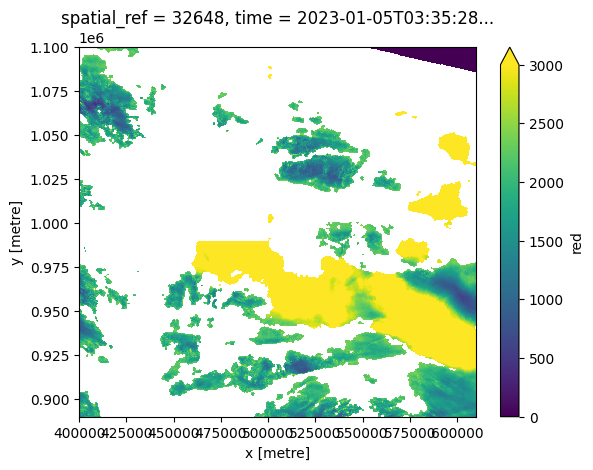

In [57]:
data.isel(time=0).red.plot.imshow(vmin=0, vmax=3000)

In [59]:
rgb = data[['red', 'green', 'blue']].isel(time=0).compute()

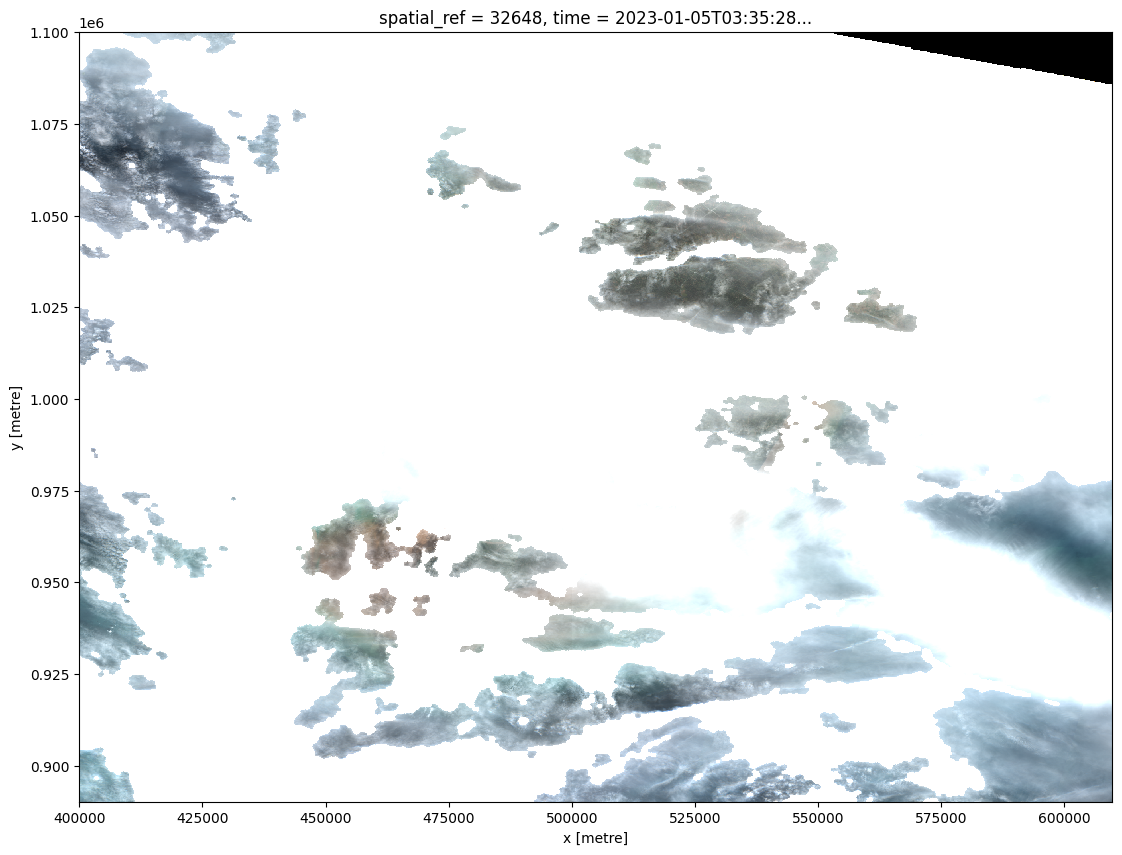

In [60]:
xr.plot.imshow(rgb.to_array(), vmin=0, vmax=3000, size=10)

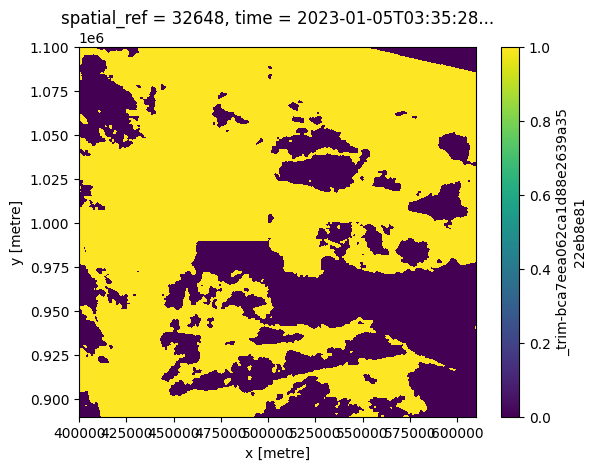

In [55]:

cloud_mask.isel(time=0).plot.imshow()

In [15]:
tides_lowres = pixel_tides(data, resample=False, directory="~/Data/tide_models_clipped")

# Calculate the lowest and highest 10% of tides
lowest_20, highest_20 = tides_lowres.quantile([0.2, 0.8]).values


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


Returning low resolution tide array


In [20]:
# Filter our data to low and high tide observations
filtered_low = tides_lowres.where(tides_lowres <= lowest_20, drop=True)
filtered_high = tides_lowres.where(tides_lowres >= highest_20, drop=True)

In [61]:
# Filter out unwanted scenes
data_low_20 = data.sel(time=filtered_low.time)
data_high_20 = data.sel(time=filtered_high.time)

In [62]:
geomad_low = geomedian_with_mads(
    data_low_20[["red", "green", "blue"]], num_threads=4, work_chunks=(1000, 1000)
).compute()

In [64]:
geomad_high = geomedian_with_mads(
    data_high_20[["red", "green", "blue"]], num_threads=4, work_chunks=(1000, 1000)
).compute()

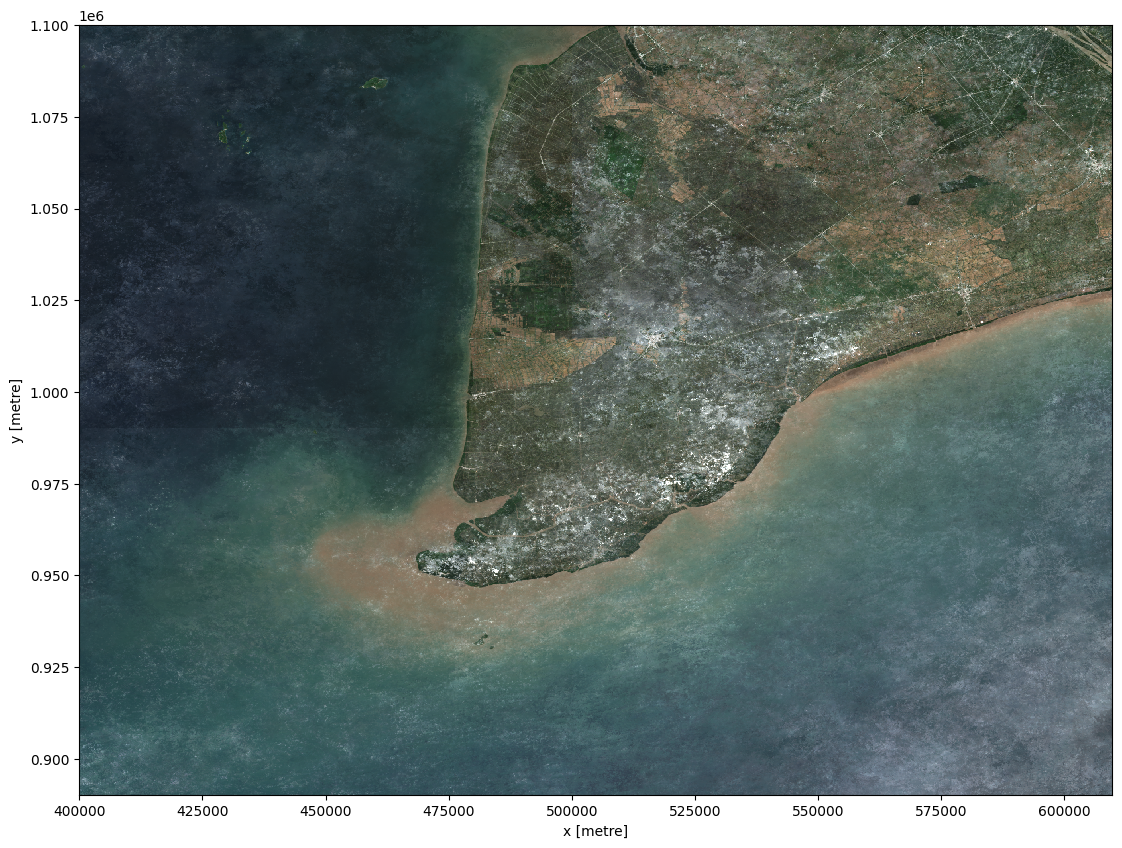

In [63]:
xr.plot.imshow(geomad_low[["red", "green", "blue"]].to_array(), size=10, vmin=0, vmax=3000)

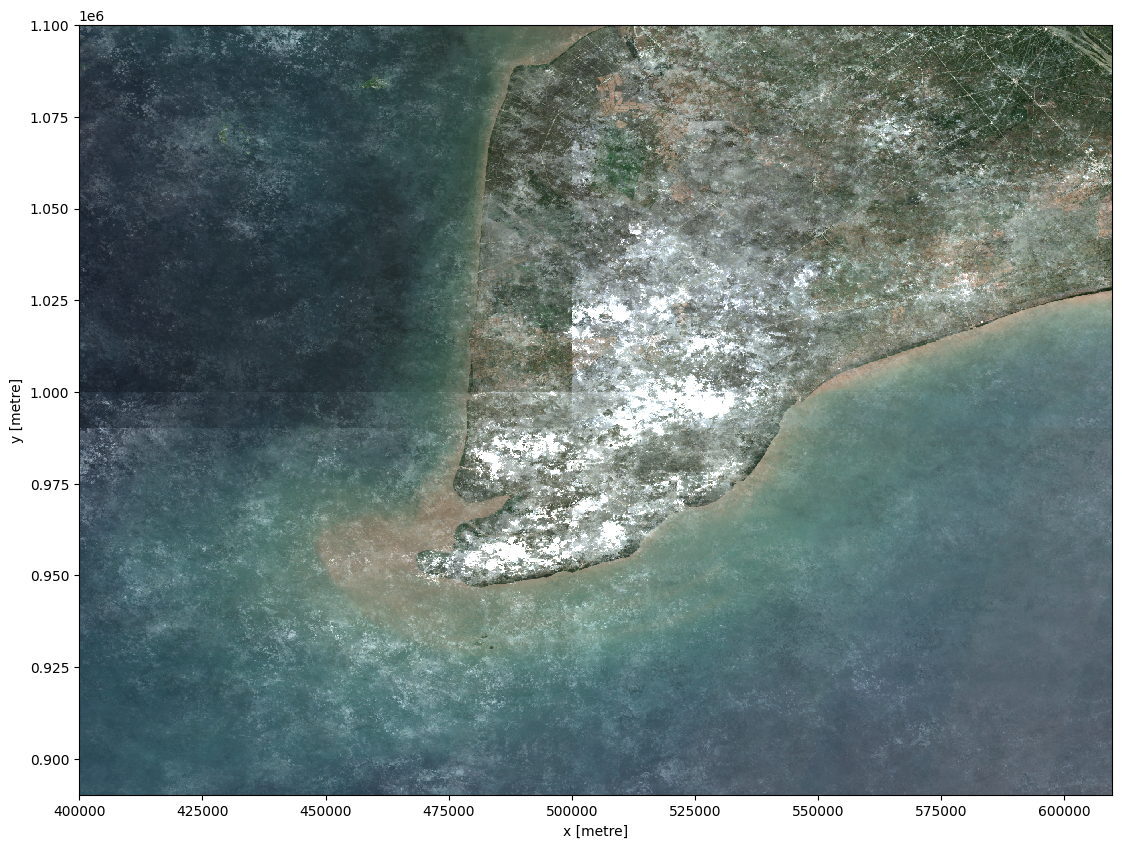

In [65]:
xr.plot.imshow(geomad_high[["red", "green", "blue"]].to_array(), size=10, vmin=0, vmax=3000)